# Exchangeable and IID probability models

If $\text{war}_i$ is the event that nuclear war breaks out in year $i$, and $\text{war}_{[N]}:=(\text{war}_1,\text{war}_2,...\text{war}_N)$ then an independent and identically distributed (IID) probability model computes the probability of no nuclear war in $N$ years as $$P^{\text{IID}}\left(\text{war}_{[N]}=(0)_{[N]}\right) = (1-p)^N$$ for some "rate" parameter $p\in [0,1]$, where $(0)_{[N]}$ is a vector consisting of $N$ zeroes.

An exchangeable model, on the other hand, employs a prior probability $Q$ on $[0,1]$ that represents "the probability that the rate parameter is $p$" and computes the probability of no nuclear war in $N$ years as $$P^{\text{exch}}\left(\text{war}_{[N]}=(0)_{[N]}\right)=\int_{[0,1]} (1-p)^N dQ(p)$$

The core assumption of an exchangeable model is that, as far as we can tell, every year is the same. This is reflected by the fact that, though the rate $p$ is unknown, it is the same for every year. If we have some knowledge that indicates that some years have higher risk than others, we should modify the model to account for this fact.

An IID model is equivalent to an exchangeable model where the prior $Q$ puts all of its weight on a particular rate, and so it represents "absolute confidence in the rate $p$". Like an exchangeable model it assumes the rate the same for every year, but it also assumes we know exactly what it is.

Below, we implement an exchangeable model of nuclear war using [numpyro](https://github.com/pyro-ppl/numpyro) and compare it to an IID model. Using numpyro is a bit of an overkill for this problem, but with a probabilistic programming language it is easy to make things a little bit more complicated, whereas with simpler methods we would quickly get stuck.

In [147]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

import jax.numpy as jnp
from jax import random, vmap

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive
sns.set()

# Priors

We need a prior probability over the annual rate of nuclear war as an input to our exchangeable model. The rate of nuclear war must be between 0 (never happens) and 1 (happens every year). [Beta distributions](https://en.wikipedia.org/wiki/Beta_distribution) are useful continuous distributions for parameters that are between 0 and 1.

A beta distribution has two parameters $(a,b)$. The mean of a beta distribution is $$\frac{a}{a+b}$$ while the variance is $$\frac{ab}{(a+b)^2(a+b+1)}$$

In general, increasing the value of both $a$ and $b$ gives us a prior that is more confident in the mean rate. The following shows how different choices of $(a,b)$ yield different levels of confidence in the rate. In each case, the distribution has a mean of $0.05$.

$B(1,1)$ is equivalent to a uniform prior. $B(500,10500)$ would give results very close to an IID distribution with absolute confidence in the rate of 5% per year.

Choosing priors is important, and it's hard to know what makes a good choice of prior. One option is to guess levels of confidence in prior ranges. For example, we can ask "what confidence do we have in the ranges $[0,0.05)$, $[0.05,0.1]$ and $(0.05,1]$?". We can then choose a distribution form (such as a Beta distribution) and some parameters that match these confidence levels. This seems a bit wooly, but I think it can be a reasonable approach. An alternative approach is below under "Principled prior selection".

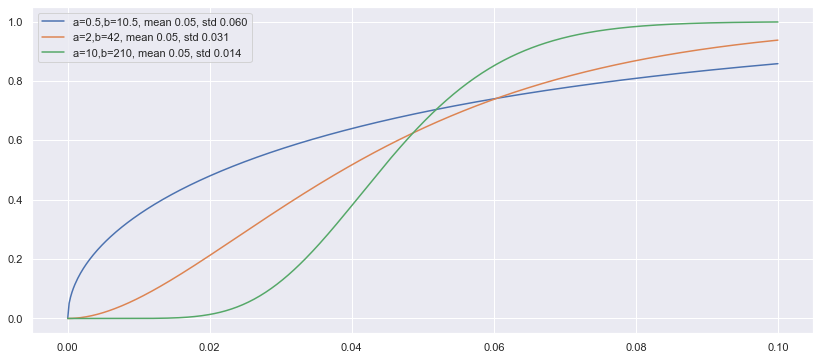

In [254]:
xs = jnp.linspace(0,0.1,500)
fig,ax = plt.subplots(figsize=(14,6))
tests = [[0.5,10.5],[2,42],[10,210]]
for a,b in tests:
    m = dist.Beta(a,b).mean
    v = np.sqrt(dist.Beta(a,b).variance)
    ax.plot(xs,dist.Beta(a,b).cdf(xs),label=f"a={a},b={b}, mean {m:.2f}, std {v:.3f}")
    
plt.legend()

# Exchangeable model of nuclear war

Here is a very simple exchangeable model of nuclear war per year. We input prior parameters $(a,b)$, and this induces a prior probability $Q$ over rates of nuclear war. The probability of nuclear war in year $i$ is them given by $$P(war_i) = \int_{[0,1]} p dQ(p)$$ where $Q$ is the prior distribution over the rate $p$.

All years share the same uncertain rate $p$. This is what makes the model exchangeable.


``with numpyro.plate('w',100):`` 

means "make 100 copies of the variables in this context."

In [253]:
def model(a,b):
    # forecasted distribution over annual probability of nuclear war
    prior_rate = numpyro.sample('rate',dist.Beta(a,b))
    with numpyro.plate('w',100):
        war = numpyro.sample('war',dist.Bernoulli(prior_rate),infer={'enumerate':'parallel'})

# Running the model

This is a bunch of crap you have to do to compute probabilities from the probability model we've constructed.

In [418]:
def run_samples_and_predict(model,
                a=1,
                b=21,
                num_warmup = 2000, 
                num_samples = 10000):
    # Start from this source of randomness. We will split keys for subsequent operations.
    rng_key = random.PRNGKey(0)
    rng_key, rng_key_ = random.split(rng_key)
     # Run NUTS.
    kernel = NUTS(model)
    mcmc = MCMC(kernel, num_warmup=num_warmup, num_samples=num_samples)
    mcmc.run(rng_key_, a,b)
    samples = mcmc.get_samples()
    predict = Predictive(model, samples, infer_discrete=True, num_samples=num_samples)
    predict_samples = predict(random.PRNGKey(1), a, b)
    return predict_samples, samples

# Effect of confidence in nuclear war rate

To illustrate the effect of limited confidence in the rate of nuclear war, we'll run two models with different priors. Both have an expectation of a 5% rate, but the first is less confident than the second. The relatively high 5% rate makes the differences between different levels more pronounced.

We also compute the likelihood of nuclear war with "absolute confidence" in the 5% rate, but we don't bother to run the model here because it reduces to an IID model discussed in the blog.

In [419]:
# Predict war over the next 100 years with low confidence in 5% rate
predict1, _ = run_samples_and_predict(model, a=1, b=21)
# Predict war over the next 100 years with higher confidence in 5% rate
predict2, _ = run_samples_and_predict(model,a=5,b=105)

sample: 100%|█| 12000/12000 [00:02<00:00, 4085.36it/s, 3 steps of size 8.35e-01.
sample: 100%|█| 12000/12000 [00:02<00:00, 4021.01it/s, 3 steps of size 1.03e+00.


In [379]:
def has_war_occurred(predict):
    hw = np.zeros(predict.shape[1])
    for i in range(predict.shape[1]):
        hw[i] = (predict[:,:i].sum(1)>0).sum()/predict.shape[0]
    return hw

/tmp/ipykernel_772344/2611028210.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['','20%','40%','60%','80%','100%'],fontsize='large')
/tmp/ipykernel_772344/2611028210.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([0,0,20,40,60,80,100],fontsize='large')


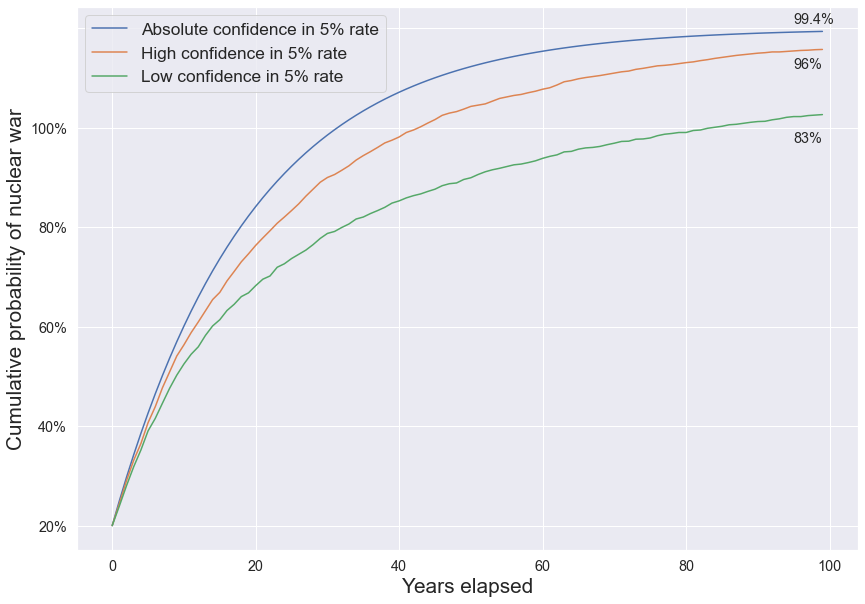

In [304]:
d = 0.95**np.arange(100)
p1 = has_war_occurred(predict1['war'])
p2 = has_war_occurred(predict2['war'])

fig,ax = plt.subplots(figsize=(14,10))
ax.plot(np.arange(100),100*(1-d),label='Absolute confidence in 5% rate')
ax.plot(np.arange(100),100*(p2),label='High confidence in 5% rate')
ax.plot(np.arange(100),100*(p1),label='Low confidence in 5% rate')
ax.text(95,101,'99.4%',fontsize='large')
ax.text(95,77,'83%',fontsize='large')
ax.text(95,92,'96%',fontsize='large')
ax.legend(fontsize='x-large')
ax.set_yticklabels(['','20%','40%','60%','80%','100%'],fontsize='large')
ax.set_xticklabels([0,0,20,40,60,80,100],fontsize='large')
ax.set_ylabel('Cumulative probability of nuclear war',size='xx-large')
ax.set_xlabel('Years elapsed',size='xx-large')
plt.savefig('nuclear_war_prob.png')

# Principled prior selection

Instead of making up a prior rate of nuclear war by feel, we can try to be a bit more deliberate about how we choose our prior. To do this, we can identify a position of maximum uncertainty and then add in different pieces of evidence to generate a prior probability.

We will say that at the start of the 20th century we are completely uncertain about the annual rate of nuclear war - so we start with a $B(1,1)$ prior. Since then, we've observed 2 direct confrontations between great powers. We are also maximally uncertain about how often confrontations between great powers turn into nuclear wars, so we will again represent the probability of nuclear war given great power confrontation as $B(1,1)$ and 0 otherwise.

We could also further reduce this to account for nuclear weapons introducing disincentives to war that weren't present, but we won't do so here.

I don't this approach is strictly better than coming up with an ad-hoc prior, but it is helpful to know different options for coming up with priors because priors are quite important and it's difficult to know if you have a good one.

An extremely handy fact here is that, starting with a uniform prior and observing $n$ wars initiated in $m$ years, the posterior probability of war initiating in a given year is $B(n+1,m-n+1)$ - see the [rule of succession](https://en.wikipedia.org/wiki/Rule_of_succession)

In [420]:
def model_alternative(wars,years):
    # 122 years, 2 wars initiated, so by the rule of succession we have B(3,120)
    war_rate = numpyro.sample('rate',dist.Beta(wars+1,years-wars+1))
    # We haven't seen any 'potentially nuclear' great power confrontations
    nuclear_if_war = numpyro.sample('nuclear_conversion',dist.Beta(1,1))
    with numpyro.plate('w',100):
        war = numpyro.sample('war',dist.Bernoulli(war_rate),infer={'enumerate':'parallel'})
        nuclear_potential = numpyro.sample('nuclear potential',dist.Bernoulli(nuclear_if_war),infer={'enumerate':'parallel'})


In [421]:
predict3_p, samp3 = run_samples_and_predict(model_alternative,2,122)
predict3 = predict3_p['war']*predict3_p['nuclear potential']

sample: 100%|█| 12000/12000 [00:03<00:00, 3221.21it/s, 3 steps of size 7.61e-01.


This model gives an initial annual credence of 1.43% in nuclear war, so we will compare it to an IID model with a 1.35% rate.

In [435]:
has_war_occurred(predict3)[1]

0.014299999922513962

/tmp/ipykernel_772344/2727031468.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['','20%','40%','60%','80%','100%'],fontsize='large')
/tmp/ipykernel_772344/2727031468.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([0,0,20,40,60,80,100],fontsize='large')


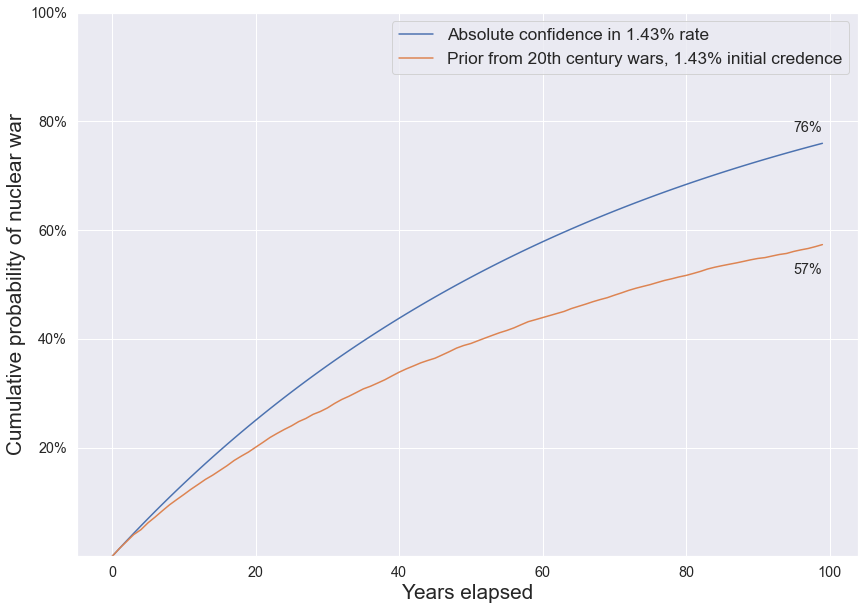

In [438]:
d = (1-0.0143)**np.arange(100)
p1 = has_war_occurred(predict3)

fig,ax = plt.subplots(figsize=(14,10))
ax.plot(np.arange(100),100*(1-d),label='Absolute confidence in 1.43% rate')
ax.plot(np.arange(100),100*(p1),label='Prior from 20th century wars, 1.43% initial credence')
ax.text(95,78,'76%',fontsize='large')
ax.text(95,52,'57%',fontsize='large')
ax.legend(fontsize='x-large')
ax.set_ylim([0,100])
ax.set_yticklabels(['','20%','40%','60%','80%','100%'],fontsize='large')
ax.set_xticklabels([0,0,20,40,60,80,100],fontsize='large')
ax.set_ylabel('Cumulative probability of nuclear war',size='xx-large')
ax.set_xlabel('Years elapsed',size='xx-large')
plt.savefig('nuclear_war_prob_2.png')

# Conditioning

We often won't have useful tricks like the rule of succession to incorporate evidence. The more general way to do this is by conditioning. At the level of model building, this means adding observed variables to our model.

In [439]:
def model_conditioned(wars,years):
    # Because the model is exchangeable, we can record wars and years in any order
    data = jnp.array([0]*(years-wars) + [1]*wars)
    # 122 years, 2 wars initiated, so by the rule of succession we have B(3,120)
    war_rate = numpyro.sample('rate',dist.Beta(1,1))
    # We haven't seen any 'potentially nuclear' great power confrontations
    nuclear_if_war = numpyro.sample('nuclear_conversion',dist.Beta(1,1))
    with numpyro.plate('w',years):
        war_obs = numpyro.sample('war_obs',dist.Bernoulli(war_rate),obs=data)
        war_unobs = numpyro.sample('war',dist.Bernoulli(war_rate),infer={'enumerate':'parallel'})
        nuclear_potential = numpyro.sample('nuclear potential',dist.Bernoulli(nuclear_if_war),infer={'enumerate':'parallel'})


In [440]:
predict4_p, samp4 = run_samples_and_predict(model_conditioned,2,122)
predict4 = predict4_p['war']*predict4_p['nuclear potential']

sample: 100%|█| 12000/12000 [00:03<00:00, 3018.86it/s, 3 steps of size 9.30e-01.


In this case, the results are almost the same as the previous model, because in this case the operations of conditioning and updating the prior are mathematically equivalent. They are only approximately the same because we use random samples to estimate the probabilities.

However, conditioning can be done even where it's not obvious how to update the prior.

In [445]:
has_war_occurred(predict3)[1], has_war_occurred(predict3)[99]

(0.014299999922513962, 0.5734000205993652)

In [446]:
has_war_occurred(predict4)[1], has_war_occurred(predict4)[99]

(0.014600000344216824, 0.5735999941825867)